<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Assignment 2*
# Convolutional Neural Networks (CNNs)

# Assignment

- <a href="#p1">Part 1:</a> Pre-Trained Model
- <a href="#p2">Part 2:</a> Custom CNN Model
- <a href="#p3">Part 3:</a> CNN with Data Augmentation


You will apply three different CNN models to a binary image classification model using Keras. Classify images of Mountains (`./data/train/mountain/*`) and images of forests (`./data/train/forest/*`). Treat mountains as the positive class (1) and the forest images as the negative (zero). 

|Mountain (+)|Forest (-)|
|---|---|
|![](./data/train/mountain/art1131.jpg)|![](./data/validation/forest/cdmc317.jpg)|

The problem is relatively difficult given that the sample is tiny: there are about 350 observations per class. This sample size might be something that you can expect with prototyping an image classification problem/solution at work. Get accustomed to evaluating several different possible models.

# Pre - Trained Model
<a id="p1"></a>

Load a pretrained network from Keras, [ResNet50](https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1) - a 50 layer deep network trained to recognize [1000 objects](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt). Starting usage:

```python
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model # This is the functional API

resnet = ResNet50(weights='imagenet', include_top=False)

```

The `include_top` parameter in `ResNet50` will remove the full connected layers from the ResNet model. The next step is to turn off the training of the ResNet layers. We want to use the learned parameters without updating them in future training passes. 

```python
for layer in resnet.layers:
    layer.trainable = False
```

Using the Keras functional API, we will need to additional additional full connected layers to our model. We we removed the top layers, we removed all preivous fully connected layers. In other words, we kept only the feature processing portions of our network. You can expert with additional layers beyond what's listed here. The `GlobalAveragePooling2D` layer functions as a really fancy flatten function by taking the average of each of the last convolutional layer outputs (which is two dimensional still). 

```python
x = resnet.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(resnet.input, predictions)
```

Your assignment is to apply the transfer learning above to classify images of Mountains (`./data/train/mountain/*`) and images of forests (`./data/train/forest/*`). Treat mountains as the positive class (1) and the forest images as the negative (zero). 

Steps to complete assignment: 
1. Load in Image Data into numpy arrays (`X`) 
2. Create a `y` for the labels
3. Train your model with pre-trained layers from resnet
4. Report your model's accuracy

## Load in Data

This surprisingly more difficult than it seems, because you are working with directories of images instead of a single file. This boiler plate will help you download a zipped version of the directory of images. The directory is organized into "train" and "validation" which you can use inside an `ImageGenerator` class to stream batches of images thru your model.  


### Download & Summarize the Data

This step is completed for you. Just run the cells and review the results. 

In [47]:
import tensorflow as tf
import os

_URL = 'https://github.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/blob/master/module2-convolutional-neural-networks/data.zip?raw=true'
windows_path = '/mnt/c/Users/tigju/Documents/Lambda School/DS Unit 4 Machine Learning/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/'
# path_to_zip = tf.keras.utils.get_file('./data.zip', origin=_URL, extract=True) # C:\Users\tigju\Documents\Lambda School\DS Unit 4 Machine Learning\DS-Unit-4-Sprint-3-Deep-Learning\module2-convolutional-neural-networks
PATH = os.path.join(windows_path, 'data')

In [48]:
PATH

'/mnt/c/Users/tigju/Documents/Lambda School/DS Unit 4 Machine Learning/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/data'

In [49]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [51]:
train_mountain_dir = os.path.join(train_dir, 'mountain')  # directory with our training cat pictures
train_forest_dir = os.path.join(train_dir, 'forest')  # directory with our training dog pictures
validation_mountain_dir = os.path.join(validation_dir, 'mountain')  # directory with our validation cat pictures
validation_forest_dir = os.path.join(validation_dir, 'forest')  # directory with our validation dog pictures

In [53]:
num_mountain_tr = len(os.listdir(train_mountain_dir))
num_forest_tr = len(os.listdir(train_forest_dir))

num_mountain_val = len(os.listdir(validation_mountain_dir))
num_forest_val = len(os.listdir(validation_forest_dir))

total_train = num_mountain_tr + num_forest_tr
total_val = num_mountain_val + num_forest_val

In [54]:
print('total training mountain images:', num_mountain_tr)
print('total training forest images:', num_forest_tr)

print('total validation mountain images:', num_mountain_val)
print('total validation forest images:', num_forest_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training mountain images: 253
total training forest images: 269
total validation mountain images: 124
total validation forest images: 61
--
Total training images: 522
Total validation images: 185


### Keras `ImageGenerator` to Process the Data

This step is completed for you, but please review the code. The `ImageGenerator` class reads in batches of data from a directory and pass them to the model one batch at a time. Just like large text files, this method is advantageous, because it stifles the need to load a bunch of images into memory. 

Check out the documentation for this class method: [Keras `ImageGenerator` Class](https://keras.io/preprocessing/image/#imagedatagenerator-class). You'll expand it's use in the third assignment objective.

In [55]:
batch_size = 16
epochs = 50
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [57]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 520 images belonging to 2 classes.


In [58]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 182 images belonging to 2 classes.


In [169]:
from skimage.io import imread_collection

#your path 
col_forest = 'data/train/forest/*.jpg'
col_mountain = 'data/train/mountain/*.jpg'

#creating a collection with the available images
collect_f = imread_collection(col_forest)
collect_m = imread_collection(col_mountain)

array([[[ 3,  0,  0],
        [ 5,  1,  0],
        [ 6,  0,  0],
        ...,
        [ 0,  0, 10],
        [10, 10, 20],
        [ 0,  0,  9]],

       [[ 3,  0,  0],
        [ 7,  1,  1],
        [ 8,  0,  0],
        ...,
        [11, 12, 17],
        [ 3,  4,  9],
        [ 0,  1,  6]],

       [[ 5,  0,  0],
        [ 9,  1,  0],
        [10,  0,  0],
        ...,
        [ 0,  1,  3],
        [ 0,  0,  2],
        [ 4,  4,  6]],

       ...,

       [[ 2,  0,  1],
        [13, 11, 12],
        [ 6,  4,  5],
        ...,
        [14,  5,  0],
        [ 8,  1,  0],
        [11,  3,  0]],

       [[ 1,  2,  6],
        [ 2,  3,  7],
        [ 0,  0,  5],
        ...,
        [ 4,  0,  0],
        [ 5,  1,  0],
        [ 4,  0,  0]],

       [[ 0,  1,  6],
        [ 0,  0,  8],
        [ 2,  5, 12],
        ...,
        [ 1,  1,  0],
        [ 2,  2,  2],
        [ 1,  1,  3]]], dtype=uint8)

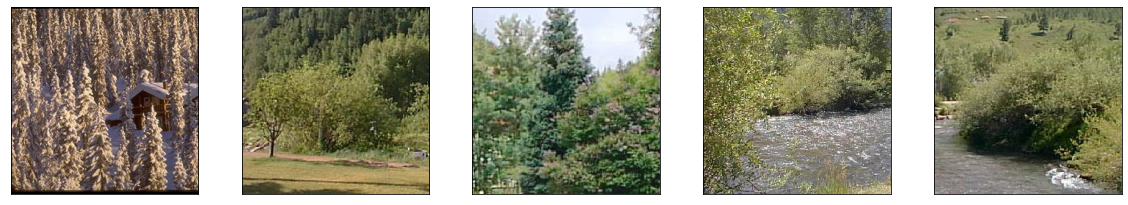

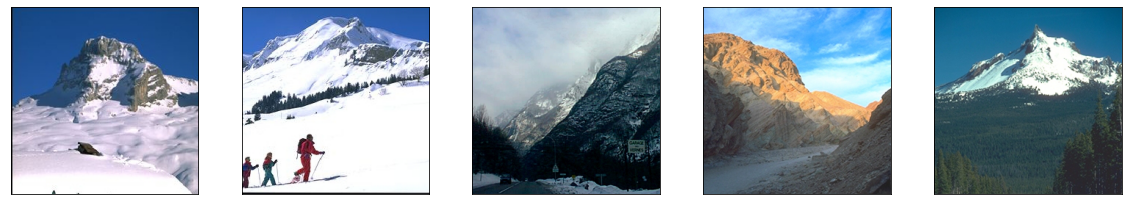

In [188]:
plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(collect_f[i], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(collect_m[i], cmap=plt.cm.binary)
plt.show()

## Instatiate Model

In [91]:
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model # This is the functional API

resnet = ResNet50(weights='imagenet', include_top=False)

In [92]:
for layer in resnet.layers:
    layer.trainable = False

In [103]:
x = resnet.output
x = GlobalAveragePooling2D()(x) # This layer is a really fancy flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(resnet.input, predictions)

In [104]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Fit Model

In [105]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/50
32/32 [==============================] - 34s 1s/step - loss: 0.7075 - accuracy: 0.6210 - val_loss: 0.5784 - val_accuracy: 0.8182
Epoch 2/50
32/32 [==============================] - 33s 1s/step - loss: 0.5622 - accuracy: 0.7123 - val_loss: 0.4793 - val_accuracy: 0.7159
Epoch 3/50
32/32 [==============================] - 35s 1s/step - loss: 0.4963 - accuracy: 0.7540 - val_loss: 0.8543 - val_accuracy: 0.4205
Epoch 4/50
32/32 [==============================] - 41s 1s/step - loss: 0.5027 - accuracy: 0.7560 - val_loss: 0.3815 - val_accuracy: 0.8750
Epoch 5/50
32/32 [==============================] - 43s 1s/step - loss: 0.4062 - accuracy: 0.8353 - val_loss: 0.3796 - val_accuracy: 0.8750
Epoch 6/50
32/32 [==============================] - 46s 1s/step - loss: 0.3466 - accuracy: 0.8829 - val_loss: 0.3568 - val_accuracy: 0.8693
Epoch 7/50
32/32 [==============================] - 36s 1s/step - loss: 0.3182 - accuracy: 0.9028 - val_loss: 0.3257 - val_accuracy: 0.9034
Epoch 8/50
32/32 [==

In [106]:
loss, acc = model.evaluate(val_data_gen)

12/12 [==============================] - 19s 2s/step - loss: 0.2054 - accuracy: 0.9396


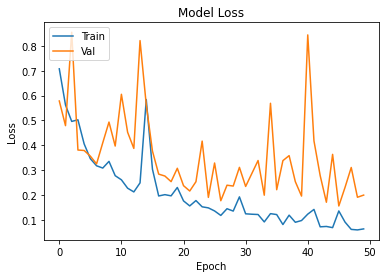

In [152]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

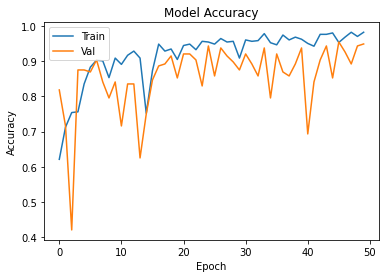

In [153]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

# Custom CNN Model

In this step, write and train your own convolutional neural network using Keras. You can use any architecture that suits you as long as it has at least one convolutional and one pooling layer at the beginning of the network - you can add more if you want. 

In [109]:
from tensorflow.keras.models import Sequential, Model # <- May Use
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [146]:
# Define the Model


custom_model = Sequential()

custom_model.add(Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)))
custom_model.add(MaxPooling2D((2,2)))
custom_model.add(Dropout(0.2))

custom_model.add(Conv2D(32, (3,3), activation='relu'))
custom_model.add(MaxPooling2D((2,2)))
custom_model.add(Dropout(0.2))

custom_model.add(Conv2D(32, (3,3), activation='relu'))
custom_model.add(Flatten())
custom_model.add(Dense(32, activation='relu'))
custom_model.add(Dropout(0.2))

custom_model.add(Dense(1, activation='sigmoid'))

custom_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 52, 52, 32)       

In [147]:
# Compile Model
custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [148]:
# Fit Model
hist = custom_model.fit(train_data_gen, 
                        epochs=10, 
                        validation_data=val_data_gen)

Epoch 1/10
33/33 [==============================] - 11s 328ms/step - loss: 0.4627 - accuracy: 0.7846 - val_loss: 0.3413 - val_accuracy: 0.8791
Epoch 2/10
33/33 [==============================] - 10s 304ms/step - loss: 0.2029 - accuracy: 0.9192 - val_loss: 0.4012 - val_accuracy: 0.8077
Epoch 3/10
33/33 [==============================] - 10s 306ms/step - loss: 0.1592 - accuracy: 0.9365 - val_loss: 0.2433 - val_accuracy: 0.9066
Epoch 4/10
33/33 [==============================] - 10s 312ms/step - loss: 0.1736 - accuracy: 0.9442 - val_loss: 0.2083 - val_accuracy: 0.9066
Epoch 5/10
33/33 [==============================] - 10s 310ms/step - loss: 0.1225 - accuracy: 0.9481 - val_loss: 0.2173 - val_accuracy: 0.9066
Epoch 6/10
33/33 [==============================] - 10s 310ms/step - loss: 0.1397 - accuracy: 0.9481 - val_loss: 0.2730 - val_accuracy: 0.8846
Epoch 7/10
33/33 [==============================] - 10s 315ms/step - loss: 0.0968 - accuracy: 0.9577 - val_loss: 0.2361 - val_accuracy: 0.8901

In [149]:
loss, acc = custom_model.evaluate(val_data_gen)

12/12 [==============================] - 1s 84ms/step - loss: 0.1914 - accuracy: 0.9396


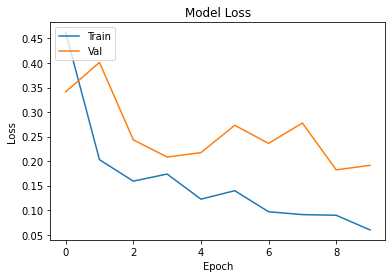

In [150]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

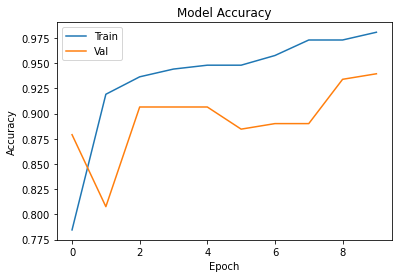

In [151]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

# Custom CNN Model with Image Manipulations

To simulate an increase in a sample of image, you can apply image manipulation techniques: cropping, rotation, stretching, etc. Luckily Keras has some handy functions for us to apply these techniques to our mountain and forest example. Simply, you should be able to modify our image generator for the problem. Check out these resources to help you get started: 

1. [Keras `ImageGenerator` Class](https://keras.io/preprocessing/image/#imagedatagenerator-class)
2. [Building a powerful image classifier with very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
 

#### model augmentation from [Building a powerful image classifier with very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

In [166]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/train/mountain/art1131.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='data/preview', save_prefix='art1131', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [167]:
from skimage.io import imread_collection

#your path 
col_dir = 'data/preview/*.jpeg'

#creating a collection with the available images
col = imread_collection(col_dir)

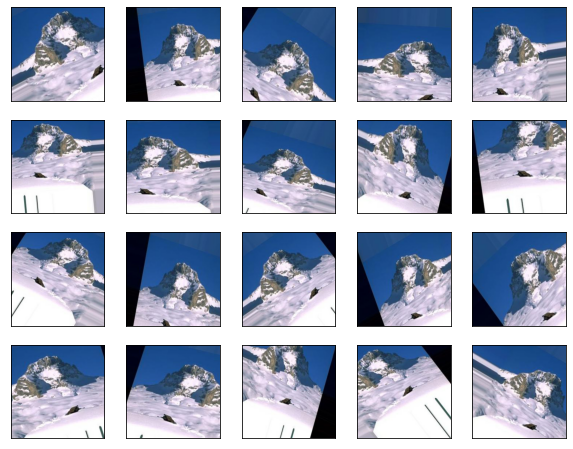

In [168]:
# see the image augmentation

plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(col[i], cmap=plt.cm.binary)
plt.show()

In [195]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model_aug = Sequential()
model_aug.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))

model_aug.add(Conv2D(32, (3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))

model_aug.add(Conv2D(64, (3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))

model_aug.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_aug.add(Dense(64))
model_aug.add(Activation('relu'))
model_aug.add(Dropout(0.5))
model_aug.add(Dense(1))
model_aug.add(Activation('sigmoid'))

In [196]:
model_aug.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

In [194]:
# generator 
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(batch_size=batch_size,
                                              directory=train_dir,
                                              shuffle=True,
                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                              class_mode='binary')

val_gen = test_datagen.flow_from_directory(batch_size=batch_size,
                                           directory=validation_dir,
                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                           class_mode='binary')

Found 520 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


In [197]:
aug_hist = model_aug.fit_generator(train_gen,
                                   steps_per_epoch=total_train // batch_size,
                                   epochs=epochs,
                                   validation_data=val_gen,
                                   validation_steps= total_val // batch_size)
model.save_weights('first_try.h5')

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/50
32/32 [==============================] - 47s 1s/step - loss: 0.7967 - accuracy: 0.7282 - val_loss: 0.8086 - val_accuracy: 0.6648
Epoch 2/50
32/32 [==============================] - 48s 1s/step - loss: 0.3537 - accuracy: 0.8631 - val_loss: 0.2527 - val_accuracy: 0.8977
Epoch 3/50
32/32 [==============================] - 47s 1s/step - loss: 0.2910 - accuracy: 0.9008 - val_loss: 0.4812 - val_accuracy: 0.8239
Epoch 4/50
32/32 [==============================] - 47s 1s/step - loss: 0.3315 - accuracy: 0.8909 - val_loss: 0.2216 - val_accuracy: 0.9148
Epoch 5/50
32/32 [==============================] - 47s 1s/step - loss: 0.2196 - accuracy: 0.9226 - val_loss: 0.3097 - val_accuracy: 0.8636
Epoch 6/50
32/32 [==============================] - 46s 1s/step - loss: 0.2381 - accuracy: 0.9087 - val_loss: 0.1480 - val_accuracy: 0.9432
Epoch 7/50
32/32 [==============================] - 46s 1s/step - loss: 0.2464 - accuracy: 0.8968 - val_loss: 0.4691 - val_accuracy: 0.8182
Epoch 8/50
32/32 [==

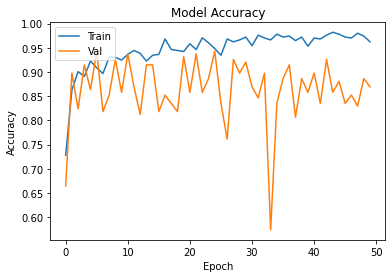

In [198]:
plt.plot(aug_hist.history['accuracy'])
plt.plot(aug_hist.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show();

# Resources and Stretch Goals

Stretch goals
- Enhance your code to use classes/functions and accept terms to search and classes to look for in recognizing the downloaded images (e.g. download images of parties, recognize all that contain balloons)
- Check out [other available pretrained networks](https://tfhub.dev), try some and compare
- Image recognition/classification is somewhat solved, but *relationships* between entities and describing an image is not - check out some of the extended resources (e.g. [Visual Genome](https://visualgenome.org/)) on the topic
- Transfer learning - using images you source yourself, [retrain a classifier](https://www.tensorflow.org/hub/tutorials/image_retraining) with a new category
- (Not CNN related) Use [piexif](https://pypi.org/project/piexif/) to check out the metadata of images passed in to your system - see if they're from a national park! (Note - many images lack GPS metadata, so this won't work in most cases, but still cool)

Resources
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) - influential paper (introduced ResNet)
- [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/) - an influential convolution based object detection system, focused on inference speed (for applications to e.g. self driving vehicles)
- [R-CNN, Fast R-CNN, Faster R-CNN, YOLO](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e) - comparison of object detection systems
- [Common Objects in Context](http://cocodataset.org/) - a large-scale object detection, segmentation, and captioning dataset
- [Visual Genome](https://visualgenome.org/) - a dataset, a knowledge base, an ongoing effort to connect structured image concepts to language